## Title and Research Questions

In [42]:
from IPython.display import Markdown, display

display(Markdown(r"""
# State-Level Energy and Electricity Analysis (2000–2023) with Energy Loss and Forecasts to 2030

**Primary Research Question**  
How have each state’s **total energy use**, **electricity use**, and **system energy loss** evolved since 2000, what **economic, demographic, and weather** factors explain those changes, **which sector contributes most** to the change, and what are **credible forecasts** through 2030?

**Sub-Questions**
1. **Trends (2000–2023):** What are the paths of **Total Energy Use (quadrillion British thermal units)**, **Electricity Use (billion kilowatt-hours)**, and **System Energy Loss (quadrillion British thermal units)** by state?
2. **Energy Loss:** How has the **System Energy Loss Rate (%)** changed, and which states improved or worsened the most?
3. **Drivers:** How do **Gross Domestic Product (billions of chained 2017 dollars)**, **Population (millions of people)**, **Heating Degree Days (base 65 degrees Fahrenheit)**, and **Cooling Degree Days (base 65 degrees Fahrenheit)** relate to energy use and loss?
4. **Composition:** For each state, which **end-use sector** (**Residential**, **Commercial**, **Industrial**, **Transportation**) contributed most to the change in **Total End-Use Energy** from 2000 to 2023?
5. **Forecasts (to 2030):** What do **state-level forecasts** look like for **Total Energy Use**, **Electricity Use**, and **System Energy Loss Rate (%)**, with **80 percent prediction intervals**?

**Dataset used:** `StatesData8_all2_ForAnalysis_2000-2023.csv`  
**Unit conventions in this notebook (for clarity):**
- Energy totals in the dataset are in **billion British thermal units**; for readability we convert to **quadrillion British thermal units** (one quadrillion British thermal units equals one million billion British thermal units).
- Electricity quantities are converted to **billion kilowatt-hours** by inferring whether the source column appears to be in **kilowatt-hours**, **megawatt-hours**, or **gigawatt-hours**.
"""))



# State-Level Energy and Electricity Analysis (2000–2023) with Energy Loss and Forecasts to 2030

**Primary Research Question**  
How have each state’s **total energy use**, **electricity use**, and **system energy loss** evolved since 2000, what **economic, demographic, and weather** factors explain those changes, **which sector contributes most** to the change, and what are **credible forecasts** through 2030?

**Sub-Questions**
1. **Trends (2000–2023):** What are the paths of **Total Energy Use (quadrillion British thermal units)**, **Electricity Use (billion kilowatt-hours)**, and **System Energy Loss (quadrillion British thermal units)** by state?
2. **Energy Loss:** How has the **System Energy Loss Rate (%)** changed, and which states improved or worsened the most?
3. **Drivers:** How do **Gross Domestic Product (billions of chained 2017 dollars)**, **Population (millions of people)**, **Heating Degree Days (base 65 degrees Fahrenheit)**, and **Cooling Degree Days (base 65 degrees Fahrenheit)** relate to energy use and loss?
4. **Composition:** For each state, which **end-use sector** (**Residential**, **Commercial**, **Industrial**, **Transportation**) contributed most to the change in **Total End-Use Energy** from 2000 to 2023?
5. **Forecasts (to 2030):** What do **state-level forecasts** look like for **Total Energy Use**, **Electricity Use**, and **System Energy Loss Rate (%)**, with **80 percent prediction intervals**?

**Dataset used:** `StatesData8_all2_ForAnalysis_2000-2023.csv`  
**Unit conventions in this notebook (for clarity):**
- Energy totals in the dataset are in **billion British thermal units**; for readability we convert to **quadrillion British thermal units** (one quadrillion British thermal units equals one million billion British thermal units).
- Electricity quantities are converted to **billion kilowatt-hours** by inferring whether the source column appears to be in **kilowatt-hours**, **megawatt-hours**, or **gigawatt-hours**.


## Imports, Plot Defaults, and Helper Functions

In [43]:
import os, re, warnings
from pathlib import Path
import numpy as np
import pandas as pd

# Plotly preferred (interactive) with Matplotlib fallback
try:
    import plotly.express as px
    import plotly.graph_objects as go
    PLOTLY_OK = True
    px.defaults.template = "plotly_white"
    px.defaults.width = 980
    px.defaults.height = 520
except Exception:
    PLOTLY_OK = False
    import matplotlib.pyplot as plt
    warnings.warn("Plotly not available. Falling back to Matplotlib.")

# Forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

# State name <-> USPS maps for readable labels and optional maps
USPS_TO_NAME = {
    'AL':'Alabama','AK':'Alaska','AZ':'Arizona','AR':'Arkansas','CA':'California','CO':'Colorado',
    'CT':'Connecticut','DE':'Delaware','FL':'Florida','GA':'Georgia','HI':'Hawaii','ID':'Idaho',
    'IL':'Illinois','IN':'Indiana','IA':'Iowa','KS':'Kansas','KY':'Kentucky','LA':'Louisiana',
    'ME':'Maine','MD':'Maryland','MA':'Massachusetts','MI':'Michigan','MN':'Minnesota','MS':'Mississippi',
    'MO':'Missouri','MT':'Montana','NE':'Nebraska','NV':'Nevada','NH':'New Hampshire','NJ':'New Jersey',
    'NM':'New Mexico','NY':'New York','NC':'North Carolina','ND':'North Dakota','OH':'Ohio','OK':'Oklahoma',
    'OR':'Oregon','PA':'Pennsylvania','RI':'Rhode Island','SC':'South Carolina','SD':'South Dakota',
    'TN':'Tennessee','TX':'Texas','UT':'Utah','VT':'Vermont','VA':'Virginia','WA':'Washington',
    'WV':'West Virginia','WI':'Wisconsin','WY':'Wyoming','DC':'District of Columbia','PR':'Puerto Rico'
}
NAME_TO_USPS = {v:k for k,v in USPS_TO_NAME.items()}

def to_quadrillion_btu_from_billion_btu(series: pd.Series) -> pd.Series:
    """Convert billion British thermal units to quadrillion British thermal units if the scale looks like billion British thermal units."""
    s = pd.to_numeric(series, errors="coerce")
    # If values are large (millions of billion British thermal units), convert to quadrillion British thermal units
    if s.dropna().median() > 1e5:
        return s / 1e6
    # Already reasonable scale; still present as quadrillion British thermal units if user prefers
    return s / 1e6

def to_billion_kwh(series: pd.Series) -> pd.Series:
    """Convert to billion kilowatt-hours by inferring the probable input unit."""
    s = pd.to_numeric(series, errors="coerce")
    med = s.dropna().median()
    if pd.isna(med):
        return s
    # If appears to be kilowatt-hours (very large values)
    if med > 1e7:
        return s / 1e9
    # If appears to be megawatt-hours
    if 1e3 <= med <= 1e7:
        return s / 1e6
    # If appears to be gigawatt-hours
    if 1 <= med < 1e3:
        return s / 1e3
    # Otherwise assume already in billion kilowatt-hours
    return s

def arima_forecast(series_values, horizon=7, orders=[(0,1,1),(1,1,0),(1,1,1),(2,1,1)]):
    """Fit a small grid of SARIMA orders and pick the lowest AIC. Return forecast mean and 80 percent interval."""
    y = pd.Series(series_values).astype(float).dropna()
    best = None
    for order in orders:
        try:
            mdl = SARIMAX(y, order=order, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
            if best is None or mdl.aic < best[0]:
                best = (mdl.aic, order, mdl)
        except Exception:
            continue
    if best is None:
        return None, None, None
    aic, order, fitted = best
    fc = fitted.get_forecast(steps=horizon)
    mean = np.array(fc.predicted_mean)
    ci = np.array(fc.conf_int(alpha=0.20))
    return order, mean, ci

def top_states_by_latest(df, value_col, k=8):
    """Pick top-k states by the latest year of value_col for clean multi-line views."""
    last = df["Year"].max()
    recent = df[df["Year"]==last][["State", value_col]].dropna()
    if recent.empty:
        return []
    return recent.sort_values(value_col, ascending=False).head(k)["State"].tolist()




## Loading Dataset

In [44]:
csv_path = "StatesData8_all2_ForAnalysis_2000-2023.csv"  # same name you provided
df_raw = pd.read_csv(csv_path)
print("Loaded:", csv_path, "| Shape:", df_raw.shape)
display(df_raw.head(10))


Loaded: StatesData8_all2_ForAnalysis_2000-2023.csv | Shape: (1248, 26)


,Year,US_first,stateId,stateDescription,GDP_Nominal,GDP_Real,pct_EneryExpend_w_GDP,EnergyUse_per_GDP,Population,EnergyUse_per_capita,...,EnergyUse1_Residential,EnergyUse2_Commercial,EnergyUse3_Industrial,EnergyUse4_Transportation,days_cooling,days_heating,ElectricityUse_EndTotal,ElectricityPrice,ElectricityExpend_EndTotal,EnergyUse5_ElecPower_import
0,2000,0,US,United States,10250952.0,14096033.0,6.71,6.86,282162.0,342.7,...,11190781.0,8216014.0,26373870.0,26479327.0,1233.0,4491.0,11673865.0,20.03,231577.5,36099936.0
1,2000,1,AK,Alaska,26934.0,38428.1,10.55,19.13,628.0,1170.9,...,35868.0,50432.0,393342.0,219733.0,4.0,10363.0,18118.0,29.60,532.0,54003.0
2,2000,1,AL,Alabama,120522.6,168695.3,9.99,12.24,4452.0,463.8,...,170802.0,107093.0,735343.0,472549.0,2052.0,2802.0,284985.0,16.60,4592.3,1182537.0
3,2000,1,AR,Arkansas,69176.3,95509.8,10.39,11.78,2679.0,419.9,...,107193.0,71334.0,339858.0,293838.0,1880.0,3565.0,141977.0,17.04,2348.6,425090.0
4,2000,1,AZ,Arizona,165735.6,224729.3,6.41,5.74,5161.0,250.0,...,137040.0,123732.0,131879.0,459904.0,3188.0,1945.0,208576.0,21.25,4431.2,862166.0
5,2000,1,CA,California,1354791.3,1784320.6,5.04,4.21,33988.0,220.8,...,839892.0,614314.0,1618092.0,3013458.0,831.0,2836.0,832723.0,27.81,22904.7,1593329.0
6,2000,1,CO,Colorado,179303.3,238739.3,4.83,5.27,4327.0,290.7,...,182341.0,134250.0,229838.0,366041.0,418.0,6877.0,146785.0,17.27,2507.8,449046.0
7,2000,1,CT,Connecticut,165523.4,233874.2,4.83,3.60,3412.0,246.5,...,177664.0,119598.0,77881.0,227972.0,360.0,6108.0,102198.0,27.91,2852.3,351181.0
8,2000,1,DC,District of Columbia,61267.7,92764.3,2.46,2.10,572.0,340.6,...,23863.0,52629.0,1498.0,26279.0,1246.0,4110.0,36220.0,22.09,799.9,2301.0
9,2000,1,DE,Delaware,43559.6,63388.8,4.44,4.79,786.0,386.4,...,33327.0,24348.0,82630.0,70445.0,870.0,4735.0,38468.0,17.86,681.8,61152.0


## Build Clean, Human-Readable Columns

In [45]:
df = df_raw.copy()

# Standard identifiers from your file
state_col = "stateDescription"   # full state name (e.g., "Colorado")
year_col  = "Year"

# Energy totals and sectors from your file
total_sector_col = "EnergyUse_SectorTotal"   # energy use across all sectors (source total)
end_total_col    = "EnergyUse_EndTotal"      # end-use energy total
elec_end_col     = "ElectricityUse_EndTotal" # end-use electricity
res_col          = "EnergyUse1_Residential"
com_col          = "EnergyUse2_Commercial"
ind_col          = "EnergyUse3_Industrial"
trans_col        = "EnergyUse4_Transportation"

# Drivers
gdp_real_col = "GDP_Real"
pop_col      = "Population"
cdd_col      = "days_cooling"
hdd_col      = "days_heating"

# 1) Basic standardization
df["State"] = df[state_col].astype(str)
df["Year"]  = pd.to_numeric(df[year_col], errors="coerce").astype("Int64")

# 2) Units: convert energy totals (billion British thermal units) -> quadrillion British thermal units
df["Total Energy Use (quadrillion British thermal units)"]     = to_quadrillion_btu_from_billion_btu(df[total_sector_col])
df["Total End-Use Energy (quadrillion British thermal units)"] = to_quadrillion_btu_from_billion_btu(df[end_total_col])

# 3) Electricity: convert to billion kilowatt-hours
if elec_end_col in df.columns:
    df["Total Electricity Use (billion kilowatt-hours)"] = to_billion_kwh(df[elec_end_col])

# 4) System Energy Loss and Loss Rate
df["System Energy Loss (quadrillion British thermal units)"] = (
    to_quadrillion_btu_from_billion_btu(df[total_sector_col]) -
    to_quadrillion_btu_from_billion_btu(df[end_total_col])
).clip(lower=0)

with np.errstate(divide="ignore", invalid="ignore"):
    loss_rate = 100 * df["System Energy Loss (quadrillion British thermal units)"] / df["Total Energy Use (quadrillion British thermal units)"]
df["System Energy Loss Rate (percent)"] = np.clip(loss_rate.fillna(0), 0, 100)

# 5) Sector energy (convert to quadrillion British thermal units)
for src_col, nice in [
    (res_col,  "Residential End-Use Energy (quadrillion British thermal units)"),
    (com_col,  "Commercial End-Use Energy (quadrillion British thermal units)"),
    (ind_col,  "Industrial End-Use Energy (quadrillion British thermal units)"),
    (trans_col,"Transportation End-Use Energy (quadrillion British thermal units)")
]:
    if src_col in df.columns:
        df[nice] = to_quadrillion_btu_from_billion_btu(df[src_col])

# 6) Drivers in human units
if gdp_real_col in df.columns:
    g = pd.to_numeric(df[gdp_real_col], errors="coerce")
    # These are dollars; present in billions of chained 2017 dollars for readability
    df["Gross Domestic Product (billions of chained 2017 dollars)"] = (g / 1e9) if g.dropna().median()>1e8 else g

if pop_col in df.columns:
    p = pd.to_numeric(df[pop_col], errors="coerce")
    df["Population (millions of people)"] = (p / 1e6) if p.dropna().median()>1e6 else p

if cdd_col in df.columns:
    df["Cooling Degree Days (base 65 degrees Fahrenheit)"] = pd.to_numeric(df[cdd_col], errors="coerce")
if hdd_col in df.columns:
    df["Heating Degree Days (base 65 degrees Fahrenheit)"] = pd.to_numeric(df[hdd_col], errors="coerce")

# Exclude aggregated United States row for state-level analysis
df_state = df[df["State"].str.strip().ne("United States")].copy()

print("Prepared columns:")
display([c for c in df_state.columns if c in [
    "State","Year",
    "Total Energy Use (quadrillion British thermal units)",
    "Total End-Use Energy (quadrillion British thermal units)",
    "System Energy Loss (quadrillion British thermal units)",
    "System Energy Loss Rate (percent)",
    "Total Electricity Use (billion kilowatt-hours)",
    "Gross Domestic Product (billions of chained 2017 dollars)",
    "Population (millions of people)",
    "Heating Degree Days (base 65 degrees Fahrenheit)",
    "Cooling Degree Days (base 65 degrees Fahrenheit)",
    "Residential End-Use Energy (quadrillion British thermal units)",
    "Commercial End-Use Energy (quadrillion British thermal units)",
    "Industrial End-Use Energy (quadrillion British thermal units)",
    "Transportation End-Use Energy (quadrillion British thermal units)"
]])


Prepared columns:


['Year',
 'State',
 'Total Energy Use (quadrillion British thermal units)',
 'Total End-Use Energy (quadrillion British thermal units)',
 'Total Electricity Use (billion kilowatt-hours)',
 'System Energy Loss (quadrillion British thermal units)',
 'System Energy Loss Rate (percent)',
 'Residential End-Use Energy (quadrillion British thermal units)',
 'Commercial End-Use Energy (quadrillion British thermal units)',
 'Industrial End-Use Energy (quadrillion British thermal units)',
 'Transportation End-Use Energy (quadrillion British thermal units)',
 'Gross Domestic Product (billions of chained 2017 dollars)',
 'Population (millions of people)',
 'Cooling Degree Days (base 65 degrees Fahrenheit)',
 'Heating Degree Days (base 65 degrees Fahrenheit)']

## Data Quality Checks and 2023 Snapshot

In [46]:
# Missing values (top few)
na = df_state.isna().sum().sort_values(ascending=False)
print("Missing values (five most):")
display(na.head(5).to_frame("Count").T)

# Snapshot for the latest year (showing top states by Total Energy Use)
latest_year = int(df_state["Year"].max())
snap = df_state[df_state["Year"]==latest_year].copy()
print(f"Snapshot for {latest_year} — top states by Total Energy Use (quadrillion British thermal units):")
display(snap.sort_values("Total Energy Use (quadrillion British thermal units)", ascending=False).head(10))


Missing values (five most):


,Year,US_first,stateId,stateDescription,GDP_Nominal
Count,0,0,0,0,0


Snapshot for 2023 — top states by Total Energy Use (quadrillion British thermal units):


,Year,US_first,stateId,stateDescription,GDP_Nominal,GDP_Real,pct_EneryExpend_w_GDP,EnergyUse_per_GDP,Population,EnergyUse_per_capita,...,System Energy Loss (quadrillion British thermal units),System Energy Loss Rate (percent),Residential End-Use Energy (quadrillion British thermal units),Commercial End-Use Energy (quadrillion British thermal units),Industrial End-Use Energy (quadrillion British thermal units),Transportation End-Use Energy (quadrillion British thermal units),Gross Domestic Product (billions of chained 2017 dollars),Population (millions of people),Cooling Degree Days (base 65 degrees Fahrenheit),Heating Degree Days (base 65 degrees Fahrenheit)
1240,2023,1,TX,Texas,2583866.2,2097090.4,6.73,6.74,30728.0,460.1,...,2.188116,15.477453,0.816674,0.821512,6.987981,3.323159,2097090.4,30728.0,3373.0,1482.0
1201,2023,1,CA,California,3870378.9,3248656.6,5.04,2.10,39199.0,173.9,...,0.799269,11.725067,0.890209,0.780742,1.313230,3.033304,3248656.6,39199.0,866.0,3085.0
1206,2023,1,FL,Florida,1600810.6,1292787.6,5.36,3.33,22905.0,187.8,...,1.178161,27.387985,0.535256,0.455352,0.361070,1.771905,1292787.6,22905.0,4031.0,429.0
1215,2023,1,LA,Louisiana,314988.6,248615.5,11.11,16.76,4588.0,908.2,...,0.416233,9.989299,0.141307,0.120030,2.738567,0.750652,248615.5,4588.0,3235.0,1260.0
1235,2023,1,PA,Pennsylvania,976360.8,799228.8,5.93,4.51,13018.0,277.1,...,0.749298,20.770515,0.517606,0.336402,1.161371,0.842831,799228.8,13018.0,656.0,4952.0
1211,2023,1,IL,Illinois,1098346.1,885651.3,4.74,3.94,12642.0,275.8,...,0.789762,22.648817,0.565665,0.410097,0.831708,0.889757,885651.3,12642.0,881.0,5320.0
1231,2023,1,NY,New York,2172009.6,1791210.7,3.41,1.92,19737.0,174.1,...,0.617847,17.976377,0.759110,0.651218,0.257808,1.151010,1791210.7,19737.0,628.0,5206.0
1232,2023,1,OH,Ohio,884834.2,709816.6,5.81,4.76,11824.0,286.0,...,0.781066,23.099768,0.499477,0.375870,0.857102,0.867756,709816.6,11824.0,689.0,4886.0
1207,2023,1,GA,Georgia,831827.7,678201.2,5.55,4.19,11064.0,256.6,...,0.793249,27.942893,0.337688,0.253602,0.533206,0.921077,678201.2,11064.0,1738.0,2292.0
1212,2023,1,IN,Indiana,499503.1,404290.3,7.06,6.32,6880.0,371.5,...,0.605846,23.703841,0.263292,0.188565,0.930349,0.567846,404290.3,6880.0,836.0,4821.0


## Trends: Energy, Electricity, and Loss

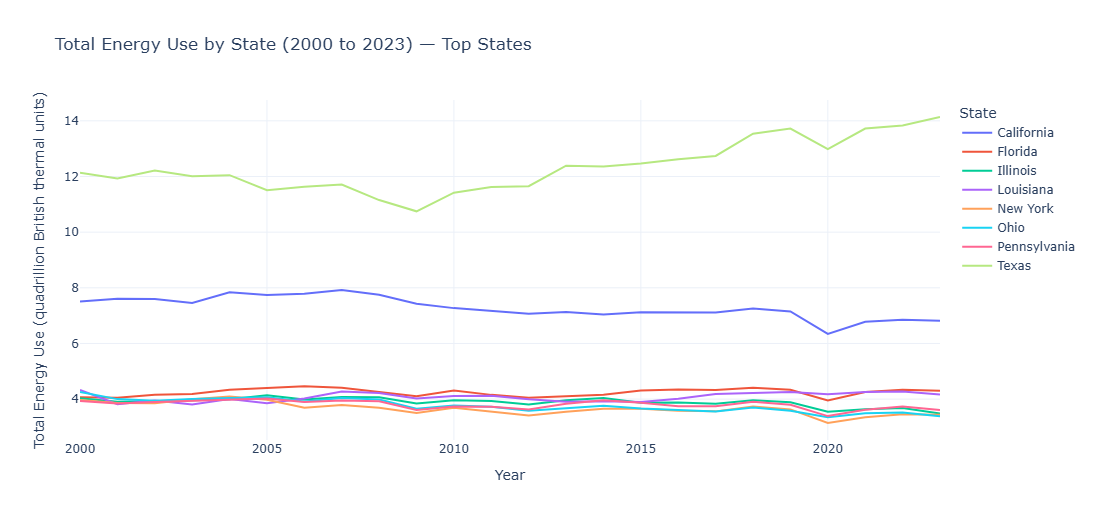

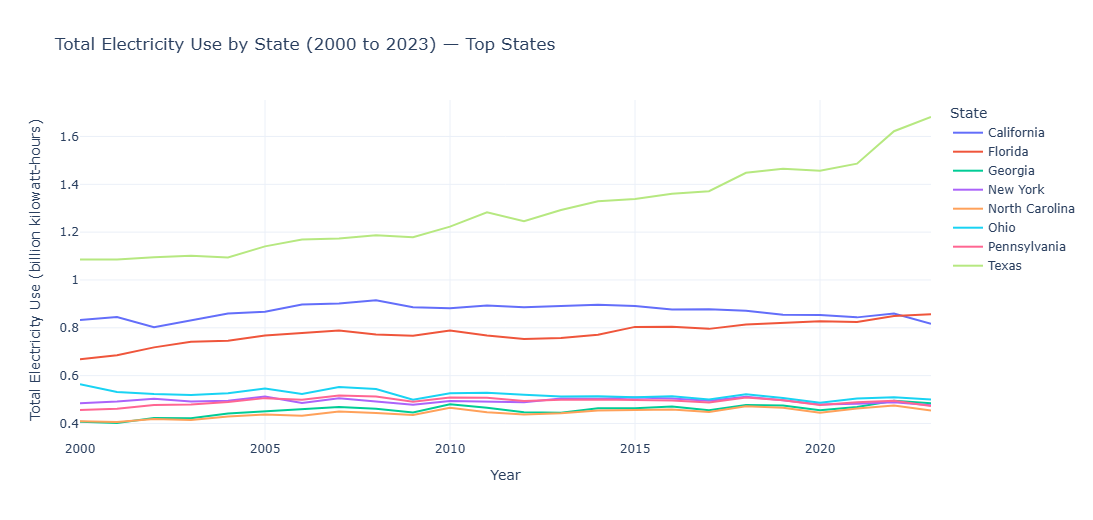

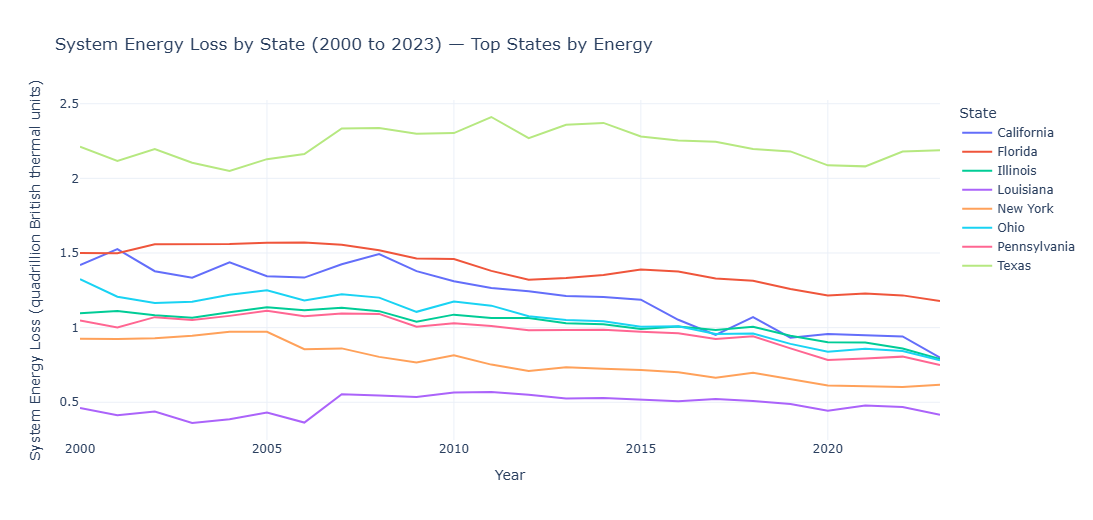

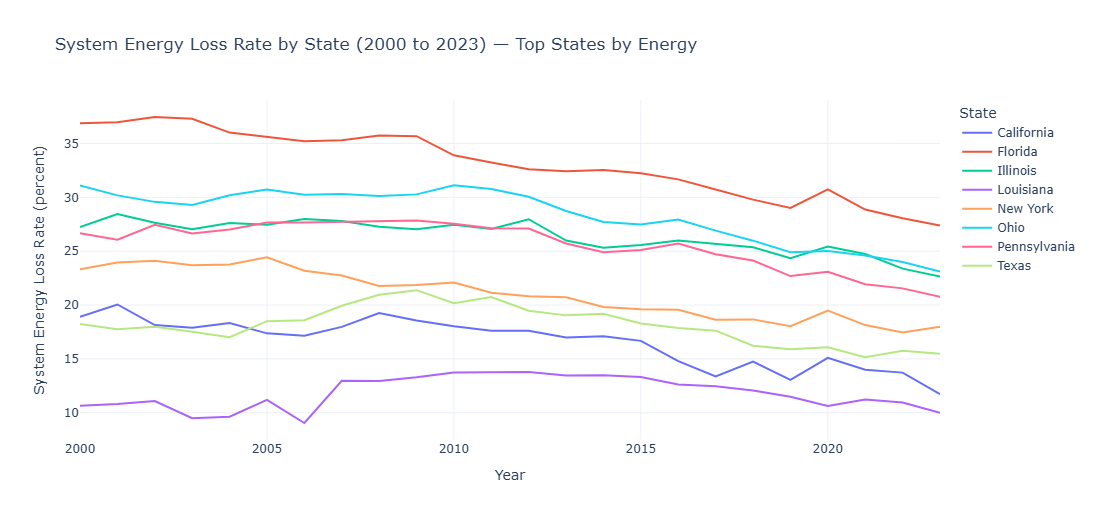

In [47]:
min_year, max_year = int(df_state["Year"].min()), int(df_state["Year"].max())
years_title = f"{min_year} to {max_year}"

energy_col = "Total Energy Use (quadrillion British thermal units)"
elec_col   = "Total Electricity Use (billion kilowatt-hours)"
loss_col   = "System Energy Loss (quadrillion British thermal units)"
rate_col   = "System Energy Loss Rate (percent)"

# Choose top states by latest energy use for uncluttered views
tops_energy = top_states_by_latest(df_state, energy_col, k=8)

def line_plot(data, y_col, title, ylab):
    if PLOTLY_OK:
        fig = px.line(
            data.sort_values(["State","Year"]),
            x="Year", y=y_col, color="State",
            title=title,
            labels={"Year":"Year", y_col: ylab, "State":"State"}
        )
        fig.update_layout(legend_title_text="State")
        fig.show()
    else:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12,6))
        for s in sorted(data["State"].unique()):
            d = data[data["State"]==s].sort_values("Year")
            plt.plot(d["Year"], d[y_col], label=s)
        plt.title(title); plt.xlabel("Year"); plt.ylabel(ylab); plt.legend(); plt.show()

# Total Energy
if energy_col in df_state:
    line_plot(df_state[df_state["State"].isin(tops_energy)], energy_col,
              f"Total Energy Use by State ({years_title}) — Top States",
              "Total Energy Use (quadrillion British thermal units)")

# Electricity
if elec_col in df_state:
    tops_elec = top_states_by_latest(df_state, elec_col, k=8)
    line_plot(df_state[df_state["State"].isin(tops_elec)], elec_col,
              f"Total Electricity Use by State ({years_title}) — Top States",
              "Total Electricity Use (billion kilowatt-hours)")

# System Energy Loss
if loss_col in df_state:
    line_plot(df_state[df_state["State"].isin(tops_energy)], loss_col,
              f"System Energy Loss by State ({years_title}) — Top States by Energy",
              "System Energy Loss (quadrillion British thermal units)")

# System Energy Loss Rate
if rate_col in df_state:
    line_plot(df_state[df_state["State"].isin(tops_energy)], rate_col,
              f"System Energy Loss Rate by State ({years_title}) — Top States by Energy",
              "System Energy Loss Rate (percent)")


## Drivers: Cross-Section Relationships

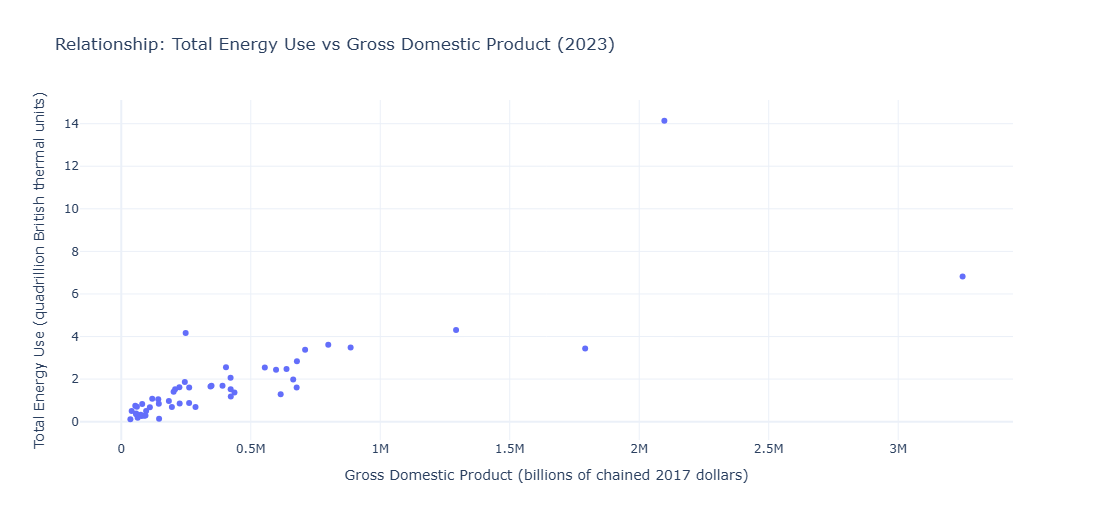

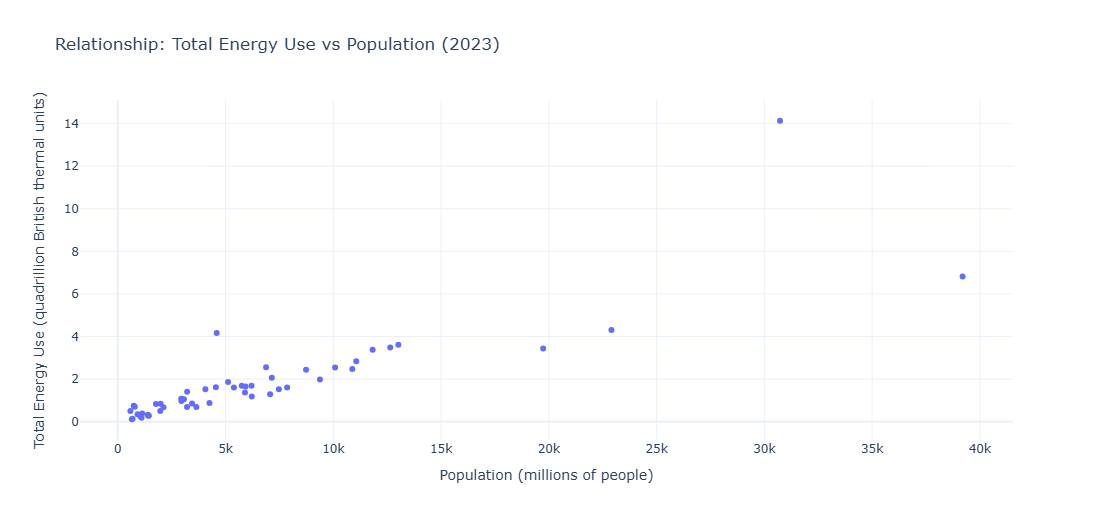

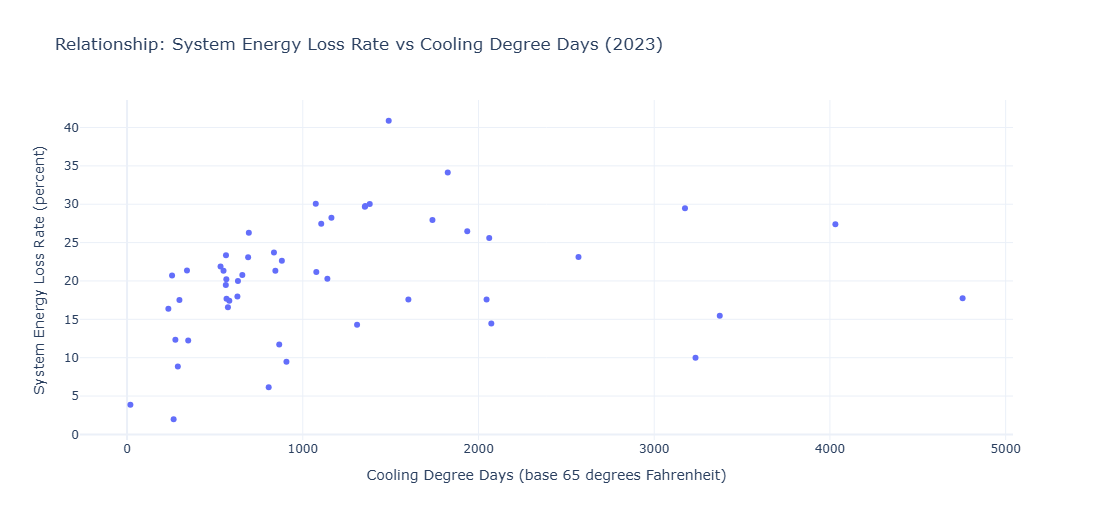

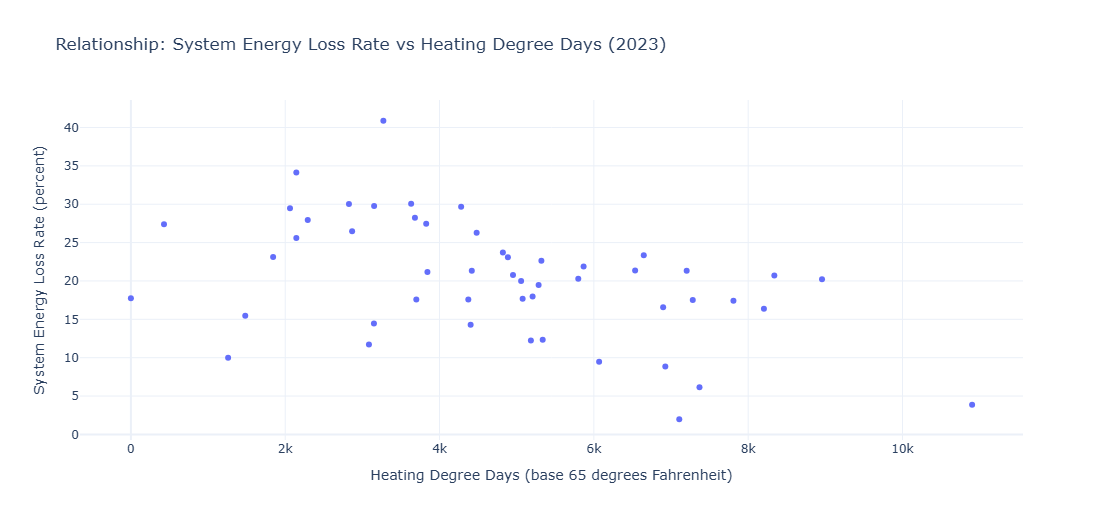

In [53]:
latest = int(df_state["Year"].max())
cross = df_state[df_state["Year"]==latest].copy()

def scatter_xy(data, x, y, title, xlab, ylab):
    if PLOTLY_OK:
        fig = px.scatter(data.dropna(subset=[x,y]), x=x, y=y, hover_name="State",
                         title=title, labels={x:xlab, y:ylab})
        fig.show()
    else:
        import matplotlib.pyplot as plt
        d = data.dropna(subset=[x,y])
        plt.figure(figsize=(8,6))
        plt.scatter(d[x], d[y])
        for _, r in d.iterrows():
            plt.annotate(r["State"], (r[x], r[y]), fontsize=8)
        plt.title(title); plt.xlabel(xlab); plt.ylabel(ylab); plt.show()

if "Gross Domestic Product (billions of chained 2017 dollars)" in cross:
    scatter_xy(cross,
               "Gross Domestic Product (billions of chained 2017 dollars)", energy_col,
               f"Relationship: Total Energy Use vs Gross Domestic Product ({latest})",
               "Gross Domestic Product (billions of chained 2017 dollars)",
               "Total Energy Use (quadrillion British thermal units)")

if "Population (millions of people)" in cross:
    scatter_xy(cross,
               "Population (millions of people)", energy_col,
               f"Relationship: Total Energy Use vs Population ({latest})",
               "Population (millions of people)",
               "Total Energy Use (quadrillion British thermal units)")

if "Cooling Degree Days (base 65 degrees Fahrenheit)" in cross:
    scatter_xy(cross,
               "Cooling Degree Days (base 65 degrees Fahrenheit)", rate_col,
               f"Relationship: System Energy Loss Rate vs Cooling Degree Days ({latest})",
               "Cooling Degree Days (base 65 degrees Fahrenheit)",
               "System Energy Loss Rate (percent)")

if "Heating Degree Days (base 65 degrees Fahrenheit)" in cross:
    scatter_xy(cross,
               "Heating Degree Days (base 65 degrees Fahrenheit)", rate_col,
               f"Relationship: System Energy Loss Rate vs Heating Degree Days ({latest})",
               "Heating Degree Days (base 65 degrees Fahrenheit)",
               "System Energy Loss Rate (percent)")


## Leaders and Laggards: Change from 2000 to 2023

In [49]:
base_year = max(2000, int(df_state["Year"].min()))
end_year  = min(2023, int(df_state["Year"].max()))

base = df_state[df_state["Year"]==base_year].set_index("State")
end  = df_state[df_state["Year"]==end_year].set_index("State")

def change_table(col, label):
    chg = (end[col] - base[col]).dropna().sort_values()
    tbl = chg.to_frame(name=f"{label} — change from {base_year} to {end_year}")
    return tbl

# Change in System Energy Loss Rate (percentage points)
if "System Energy Loss Rate (percent)" in df_state:
    chg_loss_rate = change_table("System Energy Loss Rate (percent)", "System Energy Loss Rate (percentage points)")
    print(f"Largest declines in System Energy Loss Rate (percentage points), {base_year} to {end_year}:")
    display(chg_loss_rate.head(10))
    print(f"Largest increases in System Energy Loss Rate (percentage points), {base_year} to {end_year}:")
    display(chg_loss_rate.tail(10))

# Optional bar view for largest increases
if PLOTLY_OK and "System Energy Loss Rate (percent)" in df_state:
    fig = px.bar(chg_loss_rate.tail(12).reset_index(),
                 x="State", y=chg_loss_rate.columns[0],
                 title=f"Largest increases in System Energy Loss Rate (percentage points), {base_year} to {end_year}",
                 labels={chg_loss_rate.columns[0]:"Change (percentage points)"})
    fig.show()


Largest declines in System Energy Loss Rate (percentage points), 2000 to 2023:


,System Energy Loss Rate (percentage points) — change from 2000 to 2023
State,
Iowa,-18.062712
Nevada,-14.243574
Vermont,-13.791512
Oklahoma,-11.836352
Kansas,-10.604888
Colorado,-9.925921
Nebraska,-9.521160
Florida,-9.484809
Delaware,-9.466520


Largest increases in System Energy Loss Rate (percentage points), 2000 to 2023:


,System Energy Loss Rate (percentage points) — change from 2000 to 2023
State,
New Jersey,-1.380308
New Hampshire,-1.340221
Arkansas,-1.296288
Rhode Island,-1.171021
Alaska,-1.019974
Louisiana,-0.661278
Wyoming,-0.522675
West Virginia,1.295525
Maine,1.356573


## Which Sector Contributes Most to Change (2000 → 2023)

In [50]:
# Example bar chart for one state (pick the state with the largest absolute change)
example_state = comp["Change in Total End-Use Energy (quadrillion British thermal units)"].abs().idxmax()

# Get that state's sector contributions as a Series, clean labels, and build a tidy DataFrame
row_series = comp.loc[example_state, sector_only].astype(float)
row_series.index = [idx.replace("Change from ", "") for idx in row_series.index]

row_df = row_series.reset_index()
row_df.columns = ["Sector", "Change (quadrillion British thermal units)"]
row_df = row_df.sort_values("Change (quadrillion British thermal units)", ascending=False)

# Plot
if PLOTLY_OK:
    fig = px.bar(
        row_df,
        x="Sector",
        y="Change (quadrillion British thermal units)",
        title=f"{example_state}: Sector contribution to change in Total End-Use Energy ({base_year} to {end_year})",
        labels={
            "Sector": "Sector",
            "Change (quadrillion British thermal units)": "Change (quadrillion British thermal units)"
        }
    )
    fig.update_layout(xaxis_title="Sector", yaxis_title="Change (quadrillion British thermal units)")
    fig.show()
else:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,6))
    plt.bar(row_df["Sector"], row_df["Change (quadrillion British thermal units)"])
    plt.title(f"{example_state}: Sector contribution to change in Total End-Use Energy ({base_year} to {end_year})")
    plt.xlabel("Sector")
    plt.ylabel("Change (quadrillion British thermal units)")
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()


## Forecasts to 2030 (Energy, Electricity, and Loss Rate)

Latest year in data: 2023 | Forecast horizon (years): 7


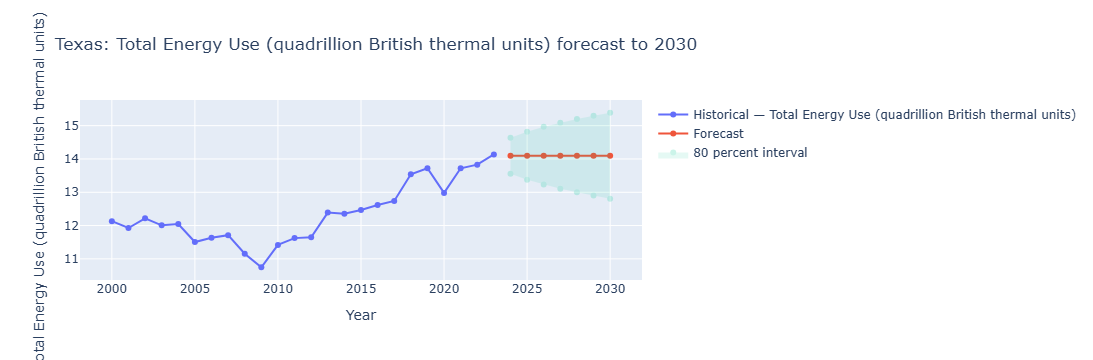

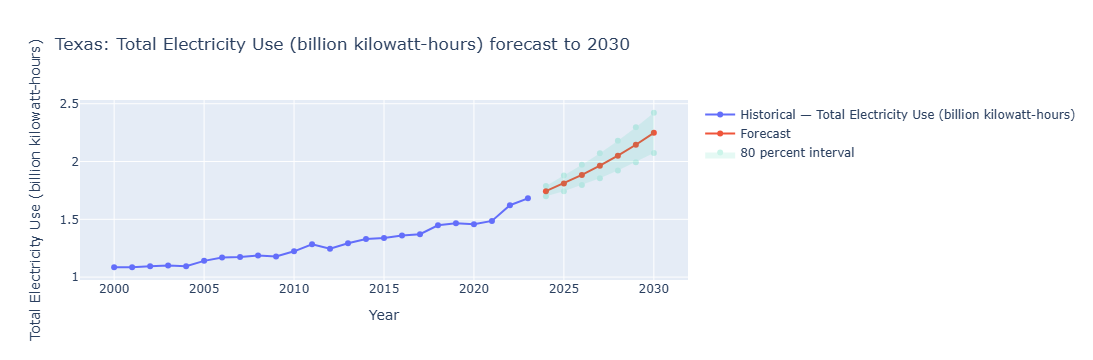

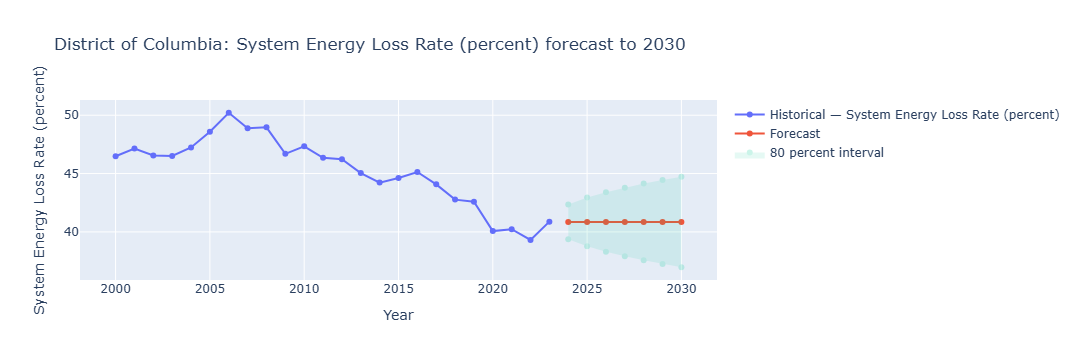

Forecast preview — energy (first 10 rows):


,State,Year,Metric,Forecast,Lower (80 percent),Upper (80 percent),Selected ARIMA Order
0,Texas,2024,Total Energy Use (quadrillion British thermal ...,14.098352,13.556361,14.640343,"(0, 1, 1)"
1,Texas,2025,Total Energy Use (quadrillion British thermal ...,14.098352,13.375866,14.820839,"(0, 1, 1)"
2,Texas,2026,Total Energy Use (quadrillion British thermal ...,14.098352,13.232200,14.964504,"(0, 1, 1)"
3,Texas,2027,Total Energy Use (quadrillion British thermal ...,14.098352,13.109185,15.087519,"(0, 1, 1)"
4,Texas,2028,Total Energy Use (quadrillion British thermal ...,14.098352,12.999861,15.196844,"(0, 1, 1)"
5,Texas,2029,Total Energy Use (quadrillion British thermal ...,14.098352,12.900472,15.296232,"(0, 1, 1)"
6,Texas,2030,Total Energy Use (quadrillion British thermal ...,14.098352,12.808721,15.387983,"(0, 1, 1)"
7,California,2024,Total Energy Use (quadrillion British thermal ...,6.824473,6.522006,7.126940,"(1, 1, 0)"
8,California,2025,Total Energy Use (quadrillion British thermal ...,6.822946,6.435192,7.210700,"(1, 1, 0)"
9,California,2026,Total Energy Use (quadrillion British thermal ...,6.823248,6.359453,7.287043,"(1, 1, 0)"


Forecast preview — electricity (first 10 rows):


,State,Year,Metric,Forecast,Lower (80 percent),Upper (80 percent),Selected ARIMA Order
0,Texas,2024,Total Electricity Use (billion kilowatt-hours),1.743483,1.698916,1.788050,"(1, 1, 1)"
1,Texas,2025,Total Electricity Use (billion kilowatt-hours),1.810911,1.743703,1.878119,"(1, 1, 1)"
2,Texas,2026,Total Electricity Use (billion kilowatt-hours),1.884264,1.796469,1.972059,"(1, 1, 1)"
3,Texas,2027,Total Electricity Use (billion kilowatt-hours),1.964064,1.855909,2.072219,"(1, 1, 1)"
4,Texas,2028,Total Electricity Use (billion kilowatt-hours),2.050877,1.921838,2.179916,"(1, 1, 1)"
5,Texas,2029,Total Electricity Use (billion kilowatt-hours),2.145320,1.994437,2.296203,"(1, 1, 1)"
6,Texas,2030,Total Electricity Use (billion kilowatt-hours),2.248062,2.074060,2.422065,"(1, 1, 1)"
7,Florida,2024,Total Electricity Use (billion kilowatt-hours),0.858524,0.838065,0.878983,"(1, 1, 0)"
8,Florida,2025,Total Electricity Use (billion kilowatt-hours),0.859266,0.825380,0.893152,"(1, 1, 0)"
9,Florida,2026,Total Electricity Use (billion kilowatt-hours),0.859504,0.814830,0.904177,"(1, 1, 0)"


Forecast preview — loss rate (first 10 rows):


,State,Year,Metric,Forecast,Lower (80 percent),Upper (80 percent),Selected ARIMA Order
0,District of Columbia,2024,System Energy Loss Rate (percent),40.853734,39.365269,42.342200,"(0, 1, 1)"
1,District of Columbia,2025,System Energy Loss Rate (percent),40.853734,38.766217,42.941252,"(0, 1, 1)"
2,District of Columbia,2026,System Energy Loss Rate (percent),40.853734,38.304239,43.403230,"(0, 1, 1)"
3,District of Columbia,2027,System Energy Loss Rate (percent),40.853734,37.913986,43.793483,"(0, 1, 1)"
4,District of Columbia,2028,System Energy Loss Rate (percent),40.853734,37.569786,44.137683,"(0, 1, 1)"
5,District of Columbia,2029,System Energy Loss Rate (percent),40.853734,37.258388,44.449081,"(0, 1, 1)"
6,District of Columbia,2030,System Energy Loss Rate (percent),40.853734,36.971890,44.735579,"(0, 1, 1)"
7,South Carolina,2024,System Energy Loss Rate (percent),34.283252,33.505896,35.060607,"(0, 1, 1)"
8,South Carolina,2025,System Energy Loss Rate (percent),34.283252,33.341071,35.225432,"(0, 1, 1)"
9,South Carolina,2026,System Energy Loss Rate (percent),34.283252,33.201066,35.365437,"(0, 1, 1)"


In [51]:
latest = int(df_state["Year"].max())
horizon = max(0, 2030 - latest)
print("Latest year in data:", latest, "| Forecast horizon (years):", horizon)

def forecast_table(df_in, metric_col, label_for_axis, top_k=8):
    if horizon <= 0 or metric_col not in df_in:
        return pd.DataFrame()

    tops = top_states_by_latest(df_in, metric_col, k=top_k)
    rows = []
    for s in tops:
        g = df_in[df_in["State"]==s].sort_values("Year")
        y = g[metric_col].astype(float).values
        if len(y) < 8:
            continue
        order, mean, ci = arima_forecast(y, horizon=horizon)
        if order is None:
            continue
        years = list(range(latest+1, latest+horizon+1))
        ci_lo = np.clip(ci[:,0], 0, None) if ci is not None else np.full_like(mean, np.nan)
        ci_hi = np.clip(ci[:,1], 0, None) if ci is not None else np.full_like(mean, np.nan)
        for i, yr in enumerate(years):
            rows.append({
                "State": s, "Year": yr, "Metric": metric_col,
                "Forecast": float(mean[i]),
                "Lower (80 percent)": float(ci_lo[i]),
                "Upper (80 percent)": float(ci_hi[i]),
                "Selected ARIMA Order": str(order)
            })
        # Example plot for the first state in list
        if PLOTLY_OK and s == tops[0]:
            hist = g[["Year", metric_col]].dropna()
            fut  = pd.DataFrame({"Year": years, "Forecast": mean,
                                 "Lower (80 percent)": ci_lo, "Upper (80 percent)": ci_hi})
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=hist["Year"], y=hist[metric_col],
                                     mode="lines+markers", name=f"Historical — {label_for_axis}"))
            fig.add_trace(go.Scatter(x=fut["Year"], y=fut["Forecast"],
                                     mode="lines+markers", name="Forecast"))
            fig.add_trace(go.Scatter(
                x=list(fut["Year"])+list(fut["Year"][::-1]),
                y=list(fut["Upper (80 percent)"])+list(fut["Lower (80 percent)"][::-1]),
                fill="toself", opacity=0.2, line=dict(width=0), name="80 percent interval"
            ))
            fig.update_layout(
                title=f"{s}: {label_for_axis} forecast to 2030",
                xaxis_title="Year", yaxis_title=label_for_axis
            )
            fig.show()

    return pd.DataFrame(rows)

# Forecast tables (top states by latest values)
fc_energy = forecast_table(df_state, "Total Energy Use (quadrillion British thermal units)",
                           "Total Energy Use (quadrillion British thermal units)", top_k=8)
fc_elec   = forecast_table(df_state, "Total Electricity Use (billion kilowatt-hours)",
                           "Total Electricity Use (billion kilowatt-hours)", top_k=8)
# Clamp loss rate to 0..100 after forecasting
fc_loss   = forecast_table(df_state.assign(**{
                    "System Energy Loss Rate (percent)": df_state["System Energy Loss Rate (percent)"].clip(0,100)
                }),
                "System Energy Loss Rate (percent)",
                "System Energy Loss Rate (percent)", top_k=8)

print("Forecast preview — energy (first 10 rows):")
display(fc_energy.head(10))
print("Forecast preview — electricity (first 10 rows):")
display(fc_elec.head(10))
print("Forecast preview — loss rate (first 10 rows):")
display(fc_loss.head(10))


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


,Model,CV_MAE_mean,TestYears,MAE,RMSE,R2,MAPE_%
0,RandomForest,2.3043,2022–2023,2.378,3.301,0.9274,4.54


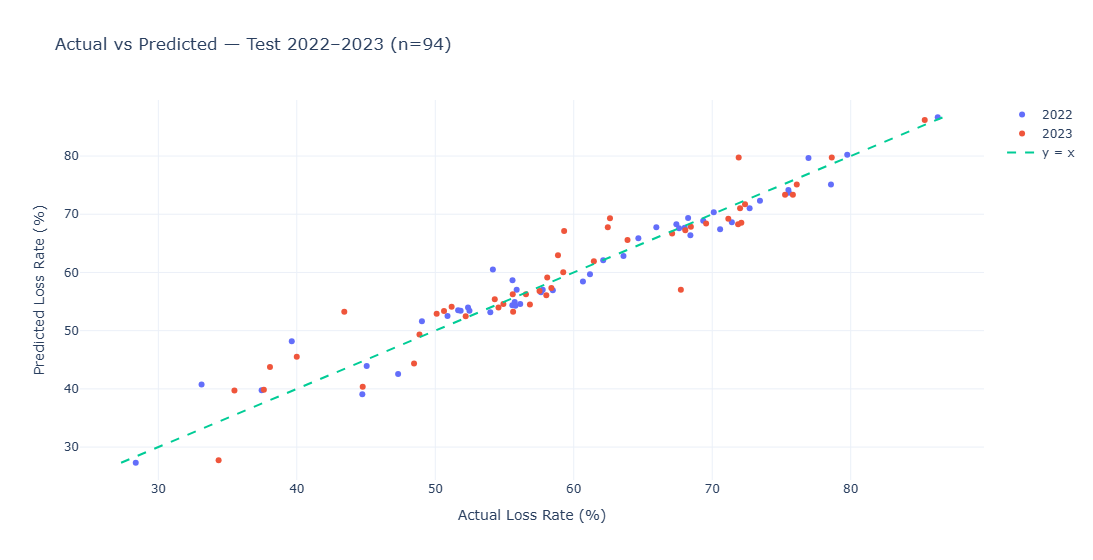

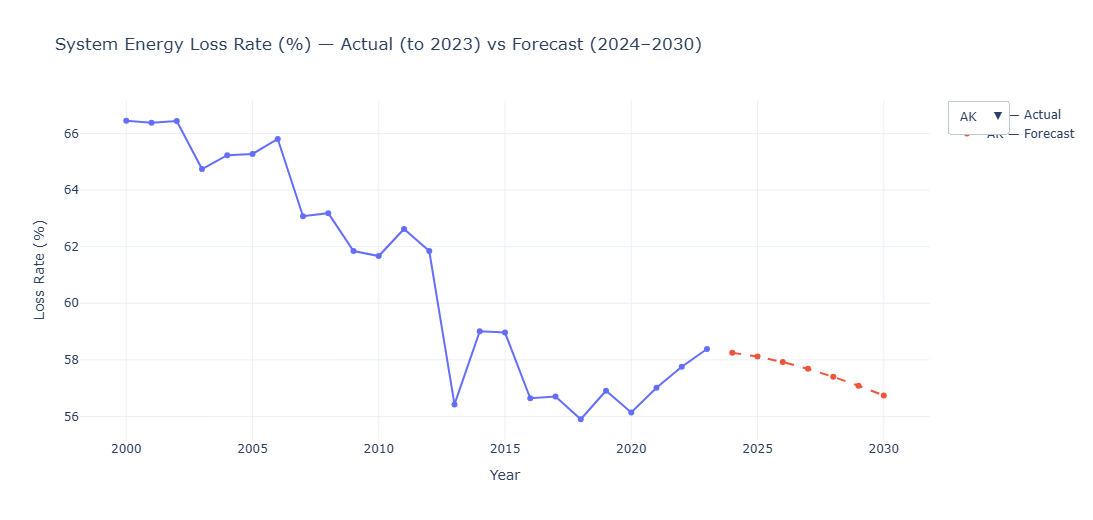

=== Final Test Summary ===
Model: RandomForest
CV_MAE_mean: 2.3043
TestYears: 2022–2023
MAE: 2.378
RMSE: 3.301
R2: 0.9274
MAPE_%: 4.54

Test sample (first 8 rows):


,stateId,Year,SystemLossRate,pred
1145,AK,2022,57.759581,57.023559
1197,AK,2023,58.382767,57.322273
1146,AL,2022,75.534320,73.678957
1198,AL,2023,75.259631,73.345276
1147,AR,2022,70.569803,67.427402
1199,AR,2023,69.558017,68.423431
1148,AZ,2022,67.409581,68.300732
1200,AZ,2023,68.456759,67.863379



Forecast table (first 12 rows):


,stateId,Year,Pred_SystemLossRate(%)
0,AK,2024,58.250
1,AK,2025,58.117
2,AK,2026,57.923
3,AK,2027,57.682
4,AK,2028,57.400
5,AK,2029,57.085
6,AK,2030,56.740
7,AL,2024,74.307
8,AL,2025,73.485
9,AL,2026,72.707



Forecast table (full):


,stateId,Year,Pred_SystemLossRate(%)
0,AK,2024,58.250
1,AK,2025,58.117
2,AK,2026,57.923
3,AK,2027,57.682
4,AK,2028,57.400
...,...,...,...
345,WY,2026,82.849
346,WY,2027,82.113
347,WY,2028,81.412
348,WY,2029,80.741


In [4]:

# ---------- Imports ----------
import os, math, warnings
import numpy as np
import pandas as pd
from IPython.display import display

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import plotly.graph_objects as go
warnings.filterwarnings("ignore")

# ---------- Config ----------
DATA_PATH = "StatesData8_all2_ForAnalysis_2000-2023.csv"  
RANDOM_STATE = 42

# ---------- Helper functions ----------
def safe_mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return float(np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])))*100.0

def compute_system_loss_rate(df, elec_in, elec_out):
    # Loss rate = (input - delivered) / input * 100
    df["SystemLoss"] = df[elec_in] - df[elec_out]
    df.loc[df[elec_in] == 0, "SystemLossRate"] = np.nan
    df.loc[df[elec_in] != 0, "SystemLossRate"] = (df["SystemLoss"] / df[elec_in]) * 100.0
    # keep realistic range
    df.loc[(df["SystemLossRate"] < 0) | (df["SystemLossRate"] > 100), "SystemLossRate"] = np.nan
    return df

def make_time_splits(model_df, year_col):
    years = sorted(model_df[year_col].unique().tolist())
    assert len(years) >= 10, "Need at least ~10 years for robust CV and test."
    test_years = years[-2:]     # e.g., 2022–2023
    val_years  = years[-6:-2]   # 4 folds right before the test window
    train_upto_cv = val_years[-1] - 1
    cv_df = model_df[model_df[year_col] <= train_upto_cv].reset_index(drop=True)

    splits = []
    for vy in val_years:
        tr_idx = cv_df.index[cv_df[year_col] <= (vy - 1)].values
        va_idx = cv_df.index[cv_df[year_col] == vy].values
        if len(tr_idx) and len(va_idx):
            splits.append((tr_idx, va_idx))
    return test_years, val_years, cv_df, splits

def time_cv_mae(pipeline, X, y, splits):
    maes = []
    for tr_idx, va_idx in splits:
        Xtr, ytr = X.iloc[tr_idx], y.iloc[tr_idx]
        Xva, yva = X.iloc[va_idx], y.iloc[va_idx]
        pipeline.fit(Xtr, ytr)
        pred = pipeline.predict(Xva)
        maes.append(mean_absolute_error(yva, pred))
    return float(np.mean(maes))

def build_tree_pipelines(feature_cols, state_col, model_df):
    # numeric imputer for robustness (lags + exogenous)
    num_imputer = SimpleImputer(strategy="median")
    prep = ColumnTransformer([
        ("num", num_imputer, [c for c in feature_cols if model_df[c].dtype != "O"]),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), [state_col])
    ], remainder="drop")

    models = {
        "GradientBoosting": GradientBoostingRegressor(
            n_estimators=900, learning_rate=0.05, max_depth=3, subsample=1.0, random_state=RANDOM_STATE
        ),
        "RandomForest": RandomForestRegressor(
            n_estimators=900, max_depth=None, min_samples_leaf=1, n_jobs=-1, max_features="sqrt", random_state=RANDOM_STATE
        ),
    }
    return {name: Pipeline([("prep", prep), ("mdl", mdl)]) for name, mdl in models.items()}

def latest_per_state(df, state_col, cols, year_col):
    """For each state, pick the latest non-null value of each exogenous column."""
    latest = {}
    for s, g in df.sort_values(year_col).groupby(state_col):
        latest[s] = {}
        for c in cols:
            series = g[c].dropna() if c in g.columns else pd.Series([], dtype=float)
            latest[s][c] = series.iloc[-1] if len(series) else np.nan
    return latest

# ---- Robust recursive forecast for tree models 
def recursive_forecast_2024_2030(pipe, df_all, state_col, year_col, feature_cols, exog_cols):
    from collections import deque

    # last two known target values per state
    state_lags = {}
    for s, g in df_all.sort_values(year_col).groupby(state_col):
        series = g["SystemLossRate"].dropna()
        if len(series) == 0:
            continue
        lag1 = series.iloc[-1]
        lag2 = series.iloc[-2] if len(series) >= 2 else series.iloc[-1]
        state_lags[s] = deque([lag1, lag2], maxlen=2)

    # exogenous values held at last known levels
    exog_latest = latest_per_state(df_all, state_col, exog_cols, year_col)

    rows = []
    for s in sorted(state_lags):
        for yr in range(2024, 2031):
            x = {
                "SystemLossRate_lag1": state_lags[s][0],
                "SystemLossRate_lag2": state_lags[s][1],
                "year_num": yr,
                state_col: s,
            }
            for c in exog_cols:
                x[c] = exog_latest[s].get(c, np.nan)
            xrow = pd.DataFrame([x], columns=feature_cols + [state_col])
            pred = float(pipe.predict(xrow)[0])
            pred = max(0.0, min(100.0, pred))  # clamp
            rows.append({state_col: s, year_col: yr, "Pred_SystemLossRate(%)": round(pred, 3)})
            state_lags[s].appendleft(pred)

    return pd.DataFrame(rows).sort_values([state_col, year_col]).reset_index(drop=True)

# ---- Clear test scatter (color by year; hover shows State + Year)
def plot_test_scatter_by_year(test_out, state_col, year_col):
    fig = go.Figure()
    for yr, sub in test_out.groupby(year_col):
        fig.add_trace(go.Scatter(
            x=sub["SystemLossRate"],
            y=sub["pred"],
            mode="markers",
            name=str(yr),
            customdata=np.stack([sub[state_col], sub[year_col]], axis=-1),
            hovertemplate="State: %{customdata[0]}<br>"
                          "Year: %{customdata[1]}<br>"
                          "Actual: %{x:.2f}%<br>"
                          "Pred: %{y:.2f}%<extra></extra>"
        ))
    lo = float(min(test_out["SystemLossRate"].min(), test_out["pred"].min()))
    hi = float(max(test_out["SystemLossRate"].max(), test_out["pred"].max()))
    fig.add_trace(go.Scatter(x=[lo, hi], y=[lo, hi], mode="lines", name="y = x",
                             line=dict(dash="dash", width=2)))
    pad = max(0.5, 0.05 * (hi - lo))
    fig.update_xaxes(range=[lo - pad, hi + pad], title="Actual Loss Rate (%)")
    fig.update_yaxes(range=[lo - pad, hi + pad], title="Predicted Loss Rate (%)")
    title_years = f"{int(test_out[year_col].min())}–{int(test_out[year_col].max())}"
    fig.update_layout(template="plotly_white", width=780, height=560,
                      title=f"Actual vs Predicted — Test {title_years} (n={len(test_out)})")
    fig.show()

def plot_state_forecast_interactive(hist_df, fcst_df, state_col, year_col, value_col="SystemLossRate"):
    states = sorted(set(fcst_df[state_col].unique()) & set(hist_df[state_col].unique()))
    if not states:
        return
    default = states[0]

    def traces(s):
        h = hist_df[(hist_df[state_col] == s) & (hist_df[value_col].notna())]
        f = fcst_df[fcst_df[state_col] == s]
        return (
            go.Scatter(x=h[year_col], y=h[value_col], mode="lines+markers", name=f"{s} — Actual"),
            go.Scatter(x=f[year_col], y=f["Pred_SystemLossRate(%)"], mode="lines+markers",
                       name=f"{s} — Forecast", line=dict(dash="dash"))
        )

    t1, t2 = traces(default)
    fig = go.Figure([t1, t2])

    buttons = []
    for s in states:
        a1, a2 = traces(s)
        buttons.append(dict(
            label=s,
            method="update",
            args=[{"x": [a1.x, a2.x], "y": [a1.y, a2.y], "name": [a1.name, a2.name]}]
        ))

    fig.update_layout(
        title="System Energy Loss Rate (%) — Actual (to 2023) vs Forecast (2024–2030)",
        xaxis_title="Year",
        yaxis_title="Loss Rate (%)",
        template="plotly_white",
        width=860, height=520,
        updatemenus=[dict(type="dropdown", x=1.02, y=1, xanchor="left", yanchor="top",
                          buttons=buttons, showactive=True)]
    )
    fig.show()

# ---------- Load & prepare data ----------
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"
df = pd.read_csv(DATA_PATH)

# Identify id columns
state_col = "stateId" if "stateId" in df.columns else ("stateDescription" if "stateDescription" in df.columns else None)
year_col  = "Year" if "Year" in df.columns else ("year" if "year" in df.columns else None)
assert state_col is not None and year_col is not None, "state/year columns not found."

# Keep only states (drop US aggregate if present)
if "stateId" in df.columns:
    df = df[df["stateId"] != "US"].copy()

# Columns needed for the target
elec_in  = "EnergyUse5_ElecPower_import"
elec_out = "ElectricityUse_EndTotal"
assert elec_in in df.columns and elec_out in df.columns, "Required electricity columns not found."

# Compute target & prep features
df = compute_system_loss_rate(df, elec_in, elec_out)
assert int(df[year_col].max()) >= 2023, "Data must include 2023 for 2024+ forecasts."

df = df.sort_values([state_col, year_col]).copy()
df["SystemLossRate_lag1"] = df.groupby(state_col)["SystemLossRate"].shift(1)
df["SystemLossRate_lag2"] = df.groupby(state_col)["SystemLossRate"].shift(2)
df["year_num"] = df[year_col].astype(int)

maybe_cols = [
    "GDP_Real","Population","days_cooling","days_heating",
    "ElectricityPrice","ElectricityExpend_EndTotal",
    "EnergyUse_Total","EnergyUse_per_GDP","EnergyUse_per_capita"
]
exog_cols = [c for c in maybe_cols if c in df.columns]  # present exogenous columns
feature_cols = exog_cols + ["SystemLossRate_lag1","SystemLossRate_lag2","year_num"]

# Training table (need target + lag1)
model_df = df.dropna(subset=["SystemLossRate","SystemLossRate_lag1"]).copy()

# ---------- CV & model selection (tree models for best near-term fit) ----------
test_years, val_years, cv_df, cv_splits = make_time_splits(model_df, year_col)
Xcv = cv_df[feature_cols + [state_col]]
ycv = cv_df["SystemLossRate"]

tree_candidates = build_tree_pipelines(feature_cols, state_col, model_df)
cv_scores = {name: time_cv_mae(pipe, Xcv, ycv, cv_splits) for name, pipe in tree_candidates.items()}
best_tree_name = min(cv_scores.keys(), key=lambda k: cv_scores[k])
best_tree_pipe = tree_candidates[best_tree_name]

# ---------- Final train/test (2022–2023) with the best tree ----------
train_df = model_df[model_df[year_col] <= (test_years[0] - 1)].copy()  # <= 2021
test_df  = model_df[model_df[year_col].isin(test_years)].copy()        # 2022–2023

Xtr = train_df[feature_cols + [state_col]]
ytr = train_df["SystemLossRate"]
Xte = test_df[feature_cols + [state_col]]
yte = test_df["SystemLossRate"]

best_tree_pipe.fit(Xtr, ytr)
yhat = best_tree_pipe.predict(Xte)

test_eval = {
    "Model": best_tree_name,
    "CV_MAE_mean": round(cv_scores[best_tree_name], 4),
    "TestYears": f"{test_years[0]}–{test_years[1]}",
    "MAE":  round(mean_absolute_error(yte, yhat), 4),
    "RMSE": round(math.sqrt(mean_squared_error(yte, yhat)), 4),
    "R2":   round(r2_score(yte, yhat), 4),
    "MAPE_%": round(safe_mape(yte, yhat), 2)
}
display(pd.DataFrame([test_eval]))

# Attach predictions for plotting
test_out = test_df[[state_col, year_col, "SystemLossRate"]].copy()
test_out["pred"] = yhat

# Plot: test 2022–2023 (color by year; hover shows state & year)
plot_test_scatter_by_year(test_out, state_col, year_col)

# ---------- Extrapolating forecast (2024–2030) using Ridge with time trend ----------

mid_year = int(model_df[year_col].median())
for _df in (df, model_df):
    _df["year_c"]  = _df["year_num"] - mid_year
    _df["year_c2"] = _df["year_c"]**2

lin_feature_cols = feature_cols + ["year_c", "year_c2"]

# Linear pipeline (scaled numerics + state OHE)
lin_prep = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("impute", SimpleImputer(strategy="median")),
                          ("scale", StandardScaler())]),
         [c for c in lin_feature_cols if model_df[c].dtype != "O"]),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), [state_col]),
    ],
    remainder="drop"
)
ridge_pipe = Pipeline([("prep", lin_prep), ("mdl", Ridge(alpha=1.0))])

# Fit Ridge on ALL history up to 2023
X_lin_all = model_df[lin_feature_cols + [state_col]]
y_lin_all = model_df["SystemLossRate"]
ridge_pipe.fit(X_lin_all, y_lin_all)

# Recursive forecast with Ridge 
def forecast_linear_recursive(pipe, df_all, state_col, year_col, lin_feature_cols, exog_cols, mid_year):
    from collections import deque
    # last two known targets per state
    lags = {}
    for s, g in df_all.sort_values(year_col).groupby(state_col):
        series = g["SystemLossRate"].dropna()
        if len(series) == 0:
            continue
        lag1 = series.iloc[-1]
        lag2 = series.iloc[-2] if len(series) >= 2 else series.iloc[-1]
        lags[s] = deque([lag1, lag2], maxlen=2)

    # hold exogenous at last known levels
    exog_latest = latest_per_state(df_all, state_col, exog_cols, year_col)

    rows = []
    for s in sorted(lags):
        for yr in range(2024, 2031):
            x = {
                "SystemLossRate_lag1": lags[s][0],
                "SystemLossRate_lag2": lags[s][1],
                "year_num": yr,
                "year_c": yr - mid_year,
                "year_c2": (yr - mid_year)**2,
                state_col: s,
            }
            for c in exog_cols:
                x[c] = exog_latest[s].get(c, np.nan)
            xrow = pd.DataFrame([x], columns=lin_feature_cols + [state_col])
            pred = float(pipe.predict(xrow)[0])
            pred = max(0.0, min(100.0, pred))  # keep in [0,100]
            rows.append({state_col: s, year_col: yr, "Pred_SystemLossRate(%)": round(pred, 3)})
            lags[s].appendleft(pred)
    return pd.DataFrame(rows).sort_values([state_col, year_col]).reset_index(drop=True)

forecast_df = forecast_linear_recursive(
    ridge_pipe, df, state_col, year_col, lin_feature_cols, exog_cols, mid_year
)

# ---------- Interactive per-state chart: history vs forecast ----------
hist_for_plot = df[[state_col, year_col, "SystemLossRate"]].copy()
plot_state_forecast_interactive(hist_for_plot, forecast_df, state_col, year_col, value_col="SystemLossRate")


print("=== Final Test Summary ===")
for k, v in test_eval.items():
    print(f"{k}: {v}")

print("\nTest sample (first 8 rows):")
display(test_out.head(8))

print("\nForecast table (first 12 rows):")
display(forecast_df.head(12))

print("\nForecast table (full):")
display(forecast_df)
